In [11]:
# original tutorial: https://docs.pymc.io/notebooks/getting_started.html

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


# Generating Data

In [41]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


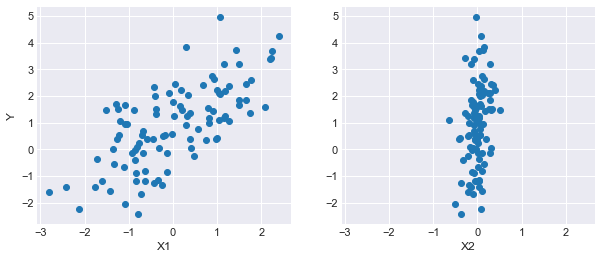

In [42]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');


In [28]:
#creates a new Model object which is a container for the model random variables.
basic_model = pm.Model()

with basic_model:
    
    # We call the Normal constructor to create a random variable to use as a normal prior. 
    # The first argument is always the name of the random variable, which should almost always match 
    # the name of the Python variable being assigned to, since it is sometimes used to retrieve the
    # variable from the model for summarizing output. The remaining required arguments for a 
    # stochastic object are the parameters, in this case mu, the mean, and sd, the standard deviation, 
    # which we assign hyperparameter values for the model. 
    #
    # In general, a distribution’s parameters are values that determine the location, 
    # shape or scale of the random variable, depending on the parameterization of the distribution. 
    # Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial
        
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2) #The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. The shape argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix values).
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome - This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the predictor variables, whatever their values may be.
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

# Model Fitting
Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the maximum a posteriori (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

## Maximum a posteriori methods¶
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.

In [32]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

/Users/m102417/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 2231.58it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [33]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3471.53draws/s]


In [34]:
# last 5 results in the trace for alpha
trace['alpha'][-5:]

array([0.97210336, 0.90132618, 0.88223011, 0.95724147, 1.02667202])

In [35]:
# last 5 results in the trace for beta
trace['beta'][-5:]

array([[0.92970773, 2.02817435],
       [0.94461984, 3.11785034],
       [0.96073879, 2.46315423],
       [0.93171976, 2.98024595],
       [0.92986459, 2.68346861]])

In [36]:
# last 5 results in the trace for sigma
trace['sigma'][-5:]

array([0.99564348, 0.97732452, 0.88532737, 1.13491555, 0.93204446])

In [37]:
# If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 2852.37draws/s]


/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


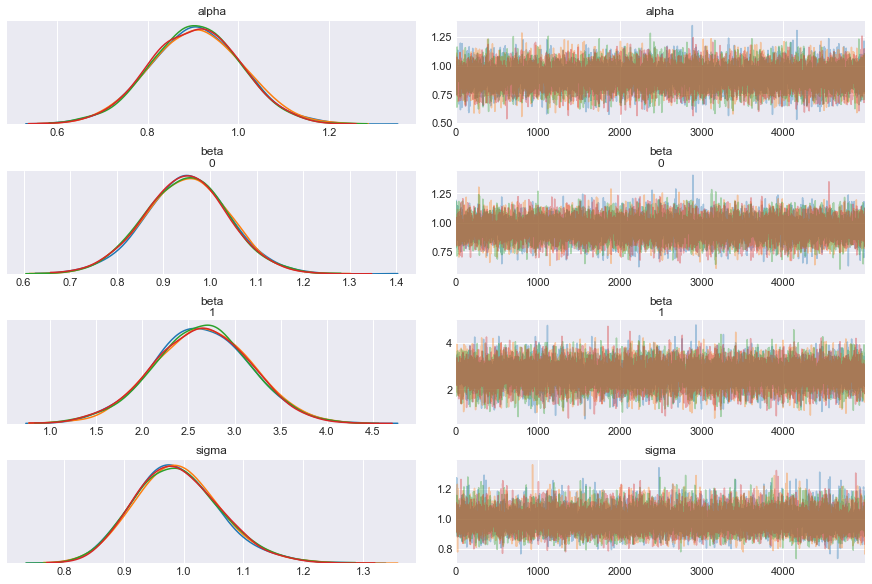

In [38]:
# PyMC3 provides plotting and summarization functions for inspecting the sampling output. 
# A simple posterior plot can be created using traceplot.
pm.traceplot(trace);


The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [39]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.0,0.72,1.11,19979.81,1.0
beta__0,0.95,0.09,0.0,0.78,1.13,19107.16,1.0
beta__1,2.65,0.52,0.0,1.60,3.65,16191.09,1.0
sigma,0.99,0.07,0.0,0.86,1.13,17898.13,1.0
